In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *
from plot_utils import *
from tqdm import tqdm

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import *

%load_ext autoreload
%autoreload 2


## configures

In [2]:
fontsize = 18
dir_name = "~/figures/BBM/"
recompute = False

# Plots in Section 2.1

## attention weights

In [3]:
torch.cuda.set_device(0)
device = 'cuda:0'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/pre-iclr/dynamics/bbm_long_train_redo"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)

In [ ]:
model_loader.change_steps(100000)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
oracle_risk = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
risk[1:3]

In [5]:
unique_x = torch.unique(x).cpu().numpy()
mask = np.isin(unique_x, ds.idxs)
mask = ~mask
mask[-1] = False
unique_x = unique_x[mask]
logits_sd = dict([(x, []) for x in unique_x])
for i in tqdm(range(128)):
    for j in range(128):
        tok = x[i, j].item()
        if tok in unique_x:
            logits_sd[tok] += outputs_list[0]['attn_logits'][i, 0, j, 1:j+1].cpu().view(-1).tolist()


for tok, logits in logits_sd.items():
    logits_sd[tok] = np.std(logits)
bos_std = outputs_list[0]['attn_logits'][:, 0, :, 0][~triggers_pos].std().cpu().detach().numpy()

100%|██████████| 128/128 [00:00<00:00, 132.83it/s]


In [6]:
np.mean(list(logits_sd.values()))

9.125276570012973

<BarContainer object of 2 artists>

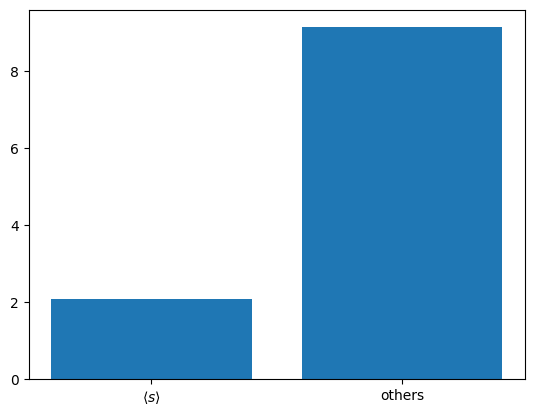

In [7]:
plt.bar([r'$\langle s \rangle$', 'others'], [bos_std, np.mean(list(logits_sd.values()))])

# randomly pick a sequence

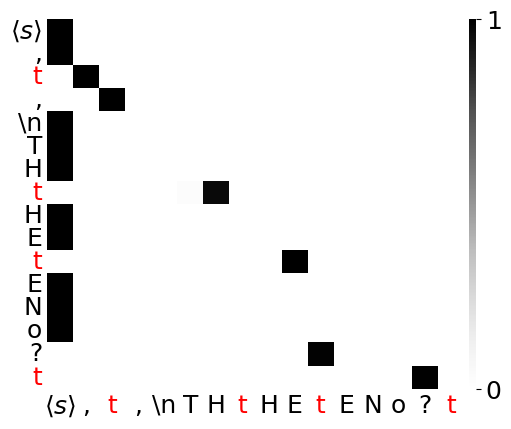

In [8]:
seq_indices = [0]
seq_len = 16
layer_idx = 0
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=[], fn=None, red_trigger=True, cmap='Greys')

# active and dormant subsequences

In [9]:
active_seq = np.array([65, 60,  1, 60, 52, 39, 59,  1, 59, 46,  1, 46, 46, 58, 39, 58, 39, 60, 43, 60, 43, 60, 39, 52,  1, 52, 57,  1, 57])
dormant_seq = np.array([65, 17, 31, 47, 52, 47, 52, 45, 50, 63,  0, 21, 26, 53, 56, 61, 39, 61, 46, 47, 50, 53, 60, 63, 53, 39, 57, 46, 39])
seqs = torch.from_numpy(np.stack((dormant_seq, active_seq), axis=0)).cuda()
predicts_plot, outputs_list_plot = model.modified_forward_with_hook(seqs, hook)
outputs_list_plot = move_device(outputs_list_plot)

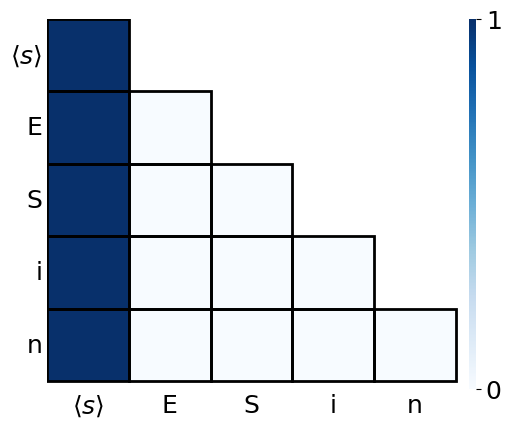

In [10]:
seq_indices = [0]
seq_len = 5
layer_idx = 0
head_idx = 0
plot_attn_weights(outputs_list_plot, seqs, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=['all_dormant.pdf'], fn=dir_name, use_grid=True, red_trigger=True)

In [11]:
outputs_list_plot[0]['attn_weights'][1, 0, 1, 1] = 100
outputs_list_plot[0]['attn_weights'][1, 0, 1, :] = outputs_list_plot[0]['attn_weights'][1, 0, 1, :]/outputs_list_plot[0]['attn_weights'][1, 0, 1, :].sum()
outputs_list_plot[0]['attn_weights'][1, 0, 3, 1:3] = 1
outputs_list_plot[0]['attn_weights'][1, 0, 3, :] = outputs_list_plot[0]['attn_weights'][1, 0, 3, :]/outputs_list_plot[0]['attn_weights'][1, 0, 3, :].sum()
outputs_list_plot[0]['attn_weights'][1, 0, 4, 2:3] = 1
outputs_list_plot[0]['attn_weights'][1, 0, 4, :] = outputs_list_plot[0]['attn_weights'][1, 0, 4, :]/outputs_list_plot[0]['attn_weights'][1, 0, 4, :].sum()

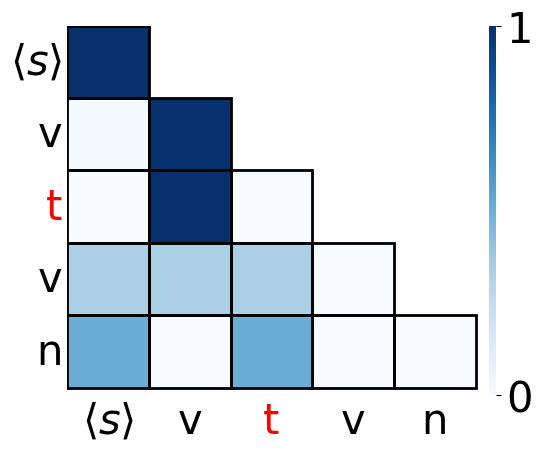

In [12]:
seq_indices = [1]
seq_len = 10
layer_idx = 0
head_idx = 0


plot_attn_weights(outputs_list_plot, seqs, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=30, titles=[], save_files_fn=["attn_fig1.pdf"], fn=dir_name, red_trigger=True, use_grid=True)

# The prediction accuracy when skipping the attn or mlp layers

In [13]:
hook_no_attn = check_embed(target_layers=[0, 1, 2], target_heads=[(0, 0), (1, 0), (2, 0)], target_mlp_layers=[])
pred_no_attn, outputs_list_no_attn = model.modified_forward_with_hook(x, hook_no_attn)
probs_no_attn = get_oracle_predicts(x, ds)
risk_no_attn = get_risk(probs, pred_no_attn, predict_in_logits=True, triggers_pos=triggers_pos)
pred_in_probs_no_attn = F.softmax(pred_no_attn, dim=-1)
risk_no_attn[1:3]

(tensor(7.6865, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(2.2299, device='cuda:0', grad_fn=<MeanBackward0>))

In [14]:
hook_no_mlp = check_embed(target_layers=[0, 1, 2], target_heads=[], target_mlp_layers=[0])
pred_no_mlp, outputs_list_no_mlp = model.modified_forward_with_hook(x, hook_no_mlp)
probs_no_mlp = get_oracle_predicts(x, ds)
risk_no_mlp = get_risk(probs, pred_no_mlp, predict_in_logits=True, triggers_pos=triggers_pos)
pred_in_probs_no_mlp = F.softmax(pred_no_mlp, dim=-1)
risk_no_mlp[1:3]

(tensor(3.1685, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(4.2132, device='cuda:0', grad_fn=<MeanBackward0>))

In [15]:
import pandas as pd
def plot_risks(risk, risk_no_attn, risk_no_mlp, fontsize=25, labels=('Backcopy loss', 'Bigram loss'), colors=('skyblue', 'lightgreen'), correction=0.05, fn=None):
    with sns.axes_style("whitegrid"):
        sns.set_context("talk")
        groups = ['Full model', 'No MLP', 'No Attn']
        values_1 = list(map(lambda x: x[1].item(), [risk, risk_no_mlp, risk_no_attn]))
        values_2 = list(map(lambda x: x[2].item(), [risk, risk_no_mlp, risk_no_attn]))
        values_1 = torch.Tensor(values_1) - oracle_risk[1].cpu()
        values_2 = torch.Tensor(values_2) - oracle_risk[2].cpu()
        values_1 = values_1.tolist()
        values_2 = values_2.tolist()
        
        # Number of groups
        n_groups = len(groups)
        bar_width = 0.35
        index = np.arange(n_groups)
        fig, ax = plt.subplots()
        ax.grid(linestyle='--')

        df = pd.DataFrame({
            'Group': groups * 2,
            'Value': values_1 + values_2,
            'Category': ['Backcopy risk'] * len(groups) + ['Bigram risk'] * len(groups)
        })

        # Create the Seaborn bar plot with error bars
        custom_colors = ['#f0f0f0', "#696969",]
        sns.barplot(x='Group', y='Value', hue='Category', data=df, palette=custom_colors, edgecolor='black', ax=ax,)
        plt.axhline(y=-math.log(1/66)-oracle_risk[2].item(), color='black', linestyle='--', label='random guess', lw=2)
        bars = ax.patches
        bars[0].set_linewidth(5)
        bars[3].set_linewidth(5)
        bars[5].set_linewidth(5)
        
        # data1 = {'text': [0.5, 1.5, 2.5], 'value': values_1}
        # sns.barplot(x='text', y='value', data=data1, facecolor='#f0f0f0', edgecolor='black', label=labels[0], ax=ax)
        # data2 = {'text': [1, 2, 3], 'value': values_2}
        # sns.barplot(x='text', y='value', data=data2, facecolor='green', edgecolor='black', label=labels[1], ax=ax)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated

        plt.xticks(rotation=0)
        ax.set_xlabel('')
        ax.set_ylabel('', fontsize=fontsize)
        # ax.set_xticks([1, 4, 6], )
        # ax.set_xticks(fontsize=fontsize)
        # ax.set_yticklabels(fontsize=fontsize)
        ax.legend(fontsize=20)
        # ax.set_xlabel('')
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')
    plt.show()
default_colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

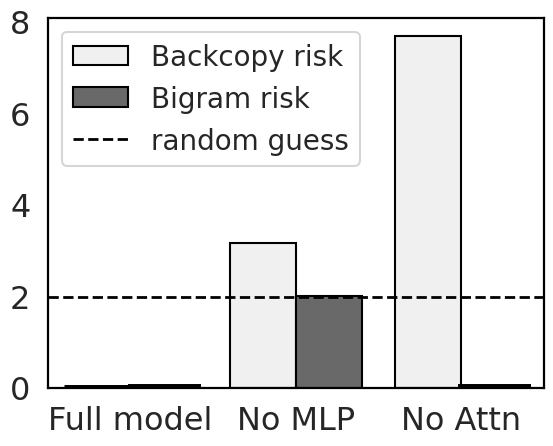

In [16]:
plot_risks(risk, risk_no_attn, risk_no_mlp, fontsize=23, colors=default_colors, correction=0.03, fn="~/figures/BBM/interventions.pdf")

In [17]:
import pandas as pd
def plot_risks(risk, risk_no_attn, risk_no_mlp, fontsize=25, labels=('Backcopy loss', 'Bigram loss'), colors=('skyblue', 'lightgreen'), correction=0.05, fn=None):
    with sns.axes_style("whitegrid"):
        sns.set_context("talk")
        # groups = ['Full model', 'No MLP', 'No Attn']
        groups = ['Bigram', 'Backcopy']
        values_1 = torch.Tensor(risk[1:3][::-1]) - torch.Tensor(oracle_risk[1:3][::-1])
        values_2 = torch.Tensor(risk_no_mlp[1:3][::-1]) - torch.Tensor(oracle_risk[1:3][::-1])
        value_3 = torch.Tensor(risk_no_attn[1:3][::-1]) - torch.Tensor(oracle_risk[1:3][::-1])
        values_1 = values_1.tolist()
        values_2 = values_2.tolist()
        value_3 = value_3.tolist()
        
        # Number of groups
        n_groups = len(groups)
        bar_width = 0.35
        index = np.arange(n_groups)
        fig, ax = plt.subplots()
        ax.grid(linestyle='--')

        df = pd.DataFrame({
            'Group': groups * 3,
            'Value': values_1 + values_2 + value_3,
            'Category': ['Full model']*2 + ['No MLP']*2 + ['No Attn']*2,
        })

        # Create the Seaborn bar plot with error bars
        custom_colors = ['#f0f0f0', "#696969", "#add8e6"]
        sns.barplot(x='Group', y='Value', hue='Category', data=df, palette=custom_colors, edgecolor='black', ax=ax)
        plt.axhline(y=-math.log(1/66)-oracle_risk[2].item(), color='black', linestyle='--', label='random guess', lw=2)
        
        # data1 = {'text': [0.5, 1.5, 2.5], 'value': values_1}
        # sns.barplot(x='text', y='value', data=data1, facecolor='#f0f0f0', edgecolor='black', label=labels[0], ax=ax)
        # data2 = {'text': [1, 2, 3], 'value': values_2}
        # sns.barplot(x='text', y='value', data=data2, facecolor='green', edgecolor='black', label=labels[1], ax=ax)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated

        plt.xticks(rotation=0)
        ax.set_xlabel('')
        # ax.set_xticks([1, 4, 6], )
        # ax.set_xticks(fontsize=fontsize)
        # ax.set_yticklabels(fontsize=fontsize)
        # plt.grid(linestyle='--', color='grey', alpha=0.5, axis='x')
        ax.legend(fontsize=20)
        ax.set_ylabel('Excess Loss')
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
    if fn is not None:
        plt.savefig(fn, bbox_inches='tight')
    plt.show()
default_colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

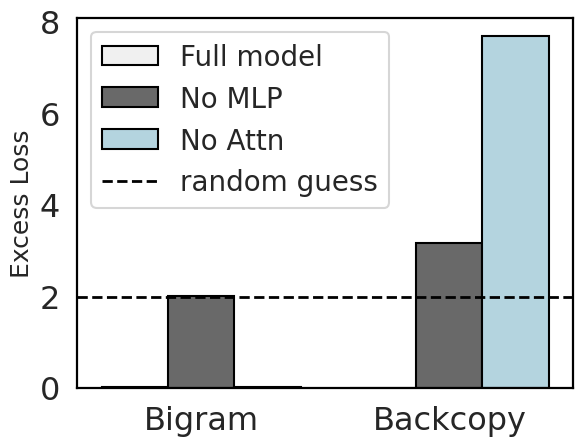

In [18]:
plot_risks(risk, risk_no_attn, risk_no_mlp, fontsize=23, colors=default_colors, correction=0.03, fn="~/figures/BBM/interventions.pdf")

## plot of value states

In [19]:
idx = 1
v_norm = model.layers[0].attention.wo(outputs_list_plot[0]['value_states'][idx, 0, :10, :].cuda()).norm(dim=-1).detach().cpu().numpy()
text = ds.decode(seqs.detach().cpu().numpy()[1, :])[:10]
text[0] = r'$\langle s \rangle$'

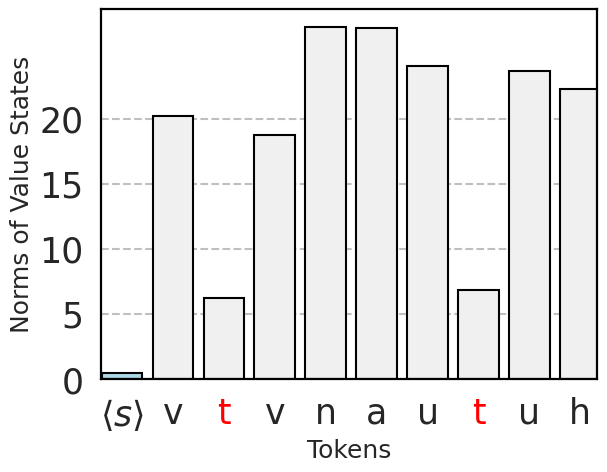

In [20]:
with sns.axes_style("whitegrid"):
    fontsize = 25
    fig, ax = plt.subplots()
    data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

    # Plot the bar plot with white facecolor and black edgecolor
    sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

    bars = ax.patches
    bars[0].set_facecolor("#add8e6")
    # Set the style and context
    sns.set_context("talk")

    # Set x and y ticks and labels
    ax.set_xticks(range(len(text)))
    ax.set_xticklabels(text, fontsize=fontsize)
    ax.set_yticks([0, 5, 10, 15, 20])
    ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)

    # Set labels
    ax.set_xlabel('Tokens', fontsize=18)
    ax.set_ylabel('Norms of Value States', fontsize=18)

    # Set gridline properties: black color and solid lines
    # ax.grid(linestyle='-', color='black')
    ax.grid(False, axis='y')

    # Customize the spines to be solid, thin, black lines
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

    # Keep x-ticks non-rotated
    plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
    plt.xticks(rotation=0)
    plt.xlim(-0.41, len(text) - 0.67)
    

    # Change the color of the x-tick label that equals 't' to red
    xticks = ax.get_xticklabels()
    for x in xticks:
        if x.get_text() == 't':
            x.set_color('red')

    # Save the figure as a PDF
    plt.savefig(os.path.join(dir_name, "value_states_white.pdf"), bbox_inches='tight')

# study the dynamics

In [21]:
torch.cuda.set_device(3)
device = 'cuda:3'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/pre-iclr/dynamics/bbm_long_train_redo"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)

In [22]:
model_loader.change_steps(100000)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]


(tensor(5.5004e-06, device='cuda:3', grad_fn=<MeanBackward0>),
 tensor(2.2299, device='cuda:3', grad_fn=<MeanBackward0>))

In [28]:
recompute = True
if recompute:
    unique_x = torch.unique(x)
    outputs_norms = {}
    logits = {}
    value_states_norm = {}
    icl_risks = {}
    markov_risks = {}
    attns_on_bos = {}
    bos_logit_differece_list = {}
    non_bos_logits_list = {}
    test_logits = {}

    with torch.no_grad():
        for step in tqdm(torch.arange(0, 1001, 20).tolist()+torch.arange(1000, 200000, 1000).tolist()):
            model_loader.change_steps(step)
            model, _, optim = model_loader(with_data=False, state_name="attn_state" if step >= 100000 else None)
            pred, outputs_list = model.modified_forward_with_hook(x, hook)
            outputs_norms[step] = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item()
            logits[step] = summarise_attns(outputs_list[0]['attn_logits'][:, 0, :, 0], x, unique_x)
            test_logits[step] = summarise_attns(outputs_list[0]['attn_logits'][:, 0, :, 0] - outputs_list[0]['attn_logits'][:, 0, :, 1], x, unique_x)
            non_bos_logits, bos_logit_differece = summarise_logits_difference(outputs_list[0]['attn_logits'][:, 0, ...], x, unique_x)
            bos_logit_differece_list[step] = bos_logit_differece
            non_bos_logits_list[step] = non_bos_logits
            attns_on_bos[step] = outputs_list[0]['attn_weights'][:, 0, :, 0][~triggers_pos].mean().detach().item()
            value_states_norm[step] = model.layers[0].attention.wo(outputs_list[0]['value_states'][idx, 0, 0, :].cuda()).norm(dim=-1).detach().cpu().numpy()
            risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
            icl_risks[step] = risk[1].item()
            markov_risks[step] = risk[2].item()
    logit_summary = torch.stack(list(logits.values()), dim=0)
    bos_logit_differece_summary = torch.stack(list(bos_logit_differece_list.values()), dim=0)
    non_bos_logits_summary = torch.stack(list(non_bos_logits_list.values()), dim=0)
    test_logits_summary = torch.stack(list(test_logits.values()), dim=0)
    torch.save((outputs_norms, logit_summary, value_states_norm, icl_risks, markov_risks, attns_on_bos, bos_logit_differece_summary, non_bos_logits_summary, test_logits_summary), "~/figures/BBM/dynamics.pt")
else:
    outputs_norms, logit_summary, value_states_norm, icl_risks, markov_risks, attns_on_bos, bos_logit_differece_summary, non_bos_logits_summary, test_logits_summary = torch.load("~/figures/BBM/dynamics.pt")

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:19<00:00, 12.70it/s]


In [29]:
unique_x = torch.unique(x).cpu()
mask = np.isin(unique_x, ds.idxs)
mask = ~mask
mask[-1] = False
mask

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False])

In [31]:
fontsize = 25
step_size = 1
x_keys = np.array(list(icl_risks.keys()))
stop_step = np.where(x_keys > 1000)[0].min()
x_keys = list(icl_risks.keys())[:stop_step][::step_size]
x_keys_2 = list(icl_risks.keys())[::step_size]

icl_y = np.array(list(icl_risks.values()))[:stop_step][::step_size]
icl_y = icl_y / icl_y.max()
markov_y = np.array(list(markov_risks.values()))[:stop_step][::step_size]
markov_y = markov_y - oracle_risk[2].item()
markov_y = markov_y / markov_y.max()
value_states_y = np.array(list(value_states_norm.values()))[:stop_step][::step_size]
value_states_y = value_states_y / value_states_y.max()
outputs_norms_y = np.array(list(outputs_norms.values()))[:stop_step][::step_size]
outputs_norms_y = outputs_norms_y / outputs_norms_y.max()
attns_on_bos_y = np.array(list(attns_on_bos.values()))[:stop_step][::step_size]
attns_on_bos_y = attns_on_bos_y / attns_on_bos_y.max()
logit_y = bos_logit_differece_summary[:, mask][::step_size].cpu()
logit_y = logit_y / logit_y.mean(dim=-1).max()
logit_y_upper = logit_y.quantile(dim=1, q=0.9)
logit_y_lower = logit_y.quantile(dim=1, q=0.1)
logit_y = logit_y.mean(dim=1)

attns_on_bos_y_2 = np.array(list(attns_on_bos.values()))[::step_size]

value_states_y_2 = np.array(list(value_states_norm.values()))[::step_size]
value_states_y_2 = value_states_y_2 / value_states_y_2.max()

fig_2_start = stop_step//step_size-1
x_keys_2 = x_keys_2[fig_2_start:]
logit_y_1 = logit_y[:fig_2_start+1]
logit_y = logit_y[fig_2_start:]
logit_y_upper = logit_y_upper[fig_2_start:]
logit_y_lower = logit_y_lower[fig_2_start:]
value_states_y_2 = value_states_y_2[fig_2_start:]
attns_on_bos_y_2 = attns_on_bos_y_2[fig_2_start:]


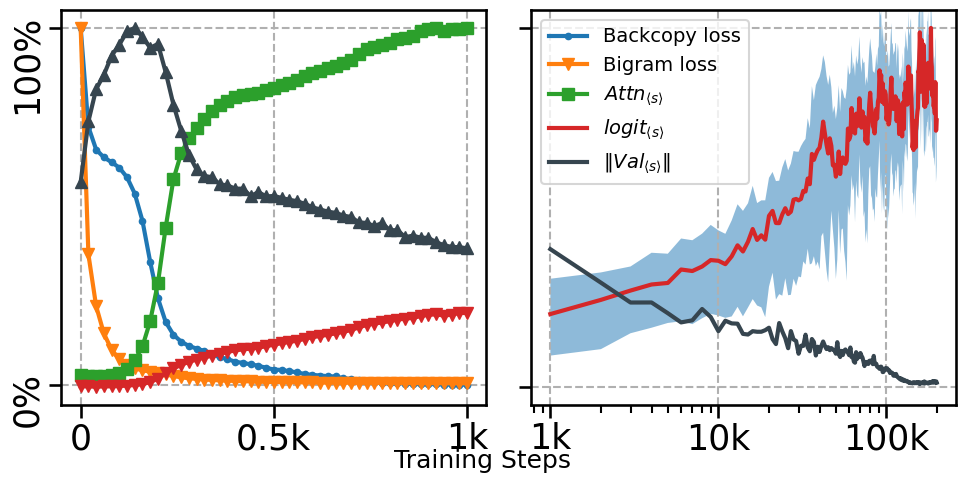

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
for i in range(2):
    ax = axes[i]
    if i == 0:
        lw = 3
        ax.plot(x_keys, icl_y, label='Backcopy loss', marker='.', lw=lw)
        ax.plot(x_keys, markov_y, label='Bigram loss', marker='v', lw=lw)
        ax.plot(x_keys, attns_on_bos_y, label=r'$Attn_{<s>}$', marker='s', lw=lw)
        ax.plot(x_keys, logit_y_1, marker='v', label=r'$Logit_{\langle s\rangle}$', lw=lw)
        ax.plot(x_keys, value_states_y, marker='^', color='#36454F', lw=lw)
        ax.grid(linestyle='--')
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0%', '100%'], fontsize=fontsize, rotation=90)
        ax.set_xticks([0, 500, 1000])
        ax.set_xticklabels([0, "0.5k", '1k'], fontsize=fontsize)
    else:
        ax.plot(-1, 2, label='Backcopy loss', marker='.', lw=lw)
        ax.plot(-1, 2, label='Bigram loss', marker='v', lw=lw)
        ax.plot(-1, 2, label=r'$Attn_{\langle s\rangle}$', marker='s', lw=lw)
        ax.plot(x_keys_2, logit_y, label=r'$logit_{\langle s\rangle}$', lw=lw)
        ax.fill_between(x_keys_2, logit_y_lower, logit_y_upper, alpha=0.5)
        ax.plot(x_keys_2, value_states_y_2, color='#36454F', label=r'$\|Val_{\langle s \rangle}\|$', lw=lw)
        ax.set_yticks([0, 1])
        ax.set_ylim(-0.05, 1.05)
        ax.set_yticklabels(['', ''], fontsize=fontsize)
        ax.set_xscale('log')
        ax.set_xticks([1000, 10000, 100000])
        ax.set_xticklabels(['1k', '10k', '100k'], fontsize=fontsize)
        ax.grid(linestyle='--')
fig.text(0.5, 0.03, 'Training Steps', ha='center', fontsize=18)
plt.tight_layout()
plt.legend(fontsize=14)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(dir_name, "dynamics_combine.pdf"), bbox_inches='tight')

In [33]:
fontsize = 25
step_size = 3
x_keys = np.array(list(icl_risks.keys()))
stop_step = np.where(x_keys > 980)[0].min()
ticksteps = [0, 200, 500, 1000, 10000, 100000]
tickx = np.isin(x_keys, ticksteps)
x_keys_1 = np.array(list(icl_risks.keys()), dtype=float)
x_keys_1[stop_step:] = np.log(x_keys_1[stop_step:])
x_keys_1[stop_step:] = (x_keys_1[stop_step:]-x_keys_1[stop_step:].min()) * 1000 / (x_keys_1[stop_step:].max()-x_keys_1[stop_step:].min()) + 1000 + x_keys_1[stop_step:].min()
x_keys_2 = list(icl_risks.keys())[:stop_step][::step_size]


icl_y = np.array(list(icl_risks.values()))
icl_y = icl_y / icl_y.max()
markov_y = np.array(list(markov_risks.values()))
markov_y = markov_y - oracle_risk[2].item()
markov_y = markov_y / markov_y.max()
value_states_y = np.array(list(value_states_norm.values()))
value_states_y = value_states_y / value_states_y.max()
outputs_norms_y = np.array(list(outputs_norms.values()))
outputs_norms_y = outputs_norms_y / outputs_norms_y.max()
attns_on_bos_y = np.array(list(attns_on_bos.values()))
attns_on_bos_y = attns_on_bos_y / attns_on_bos_y.max()
logit_y = bos_logit_differece_summary[:, mask].cpu()
logit_y = logit_y / logit_y.mean(dim=-1).max()
logit_y_upper = logit_y.quantile(dim=1, q=0.9)
logit_y_lower = logit_y.quantile(dim=1, q=0.1)
logit_y = logit_y.mean(dim=1)

icl_y_1, markov_y_1, value_states_y_1, outputs_norms_y_1, attns_on_bos_y_1 = icl_y, markov_y, value_states_y, outputs_norms_y, attns_on_bos_y
logit_y_1, logit_y_upper_1, logit_y_lower_1 = logit_y, logit_y_upper, logit_y_lower
icl_y_2, markov_y_2, value_states_y_2, outputs_norms_y_2, attns_on_bos_y_2 = icl_y[:stop_step][::step_size], markov_y[:stop_step][::step_size], value_states_y[:stop_step][::step_size], outputs_norms_y[:stop_step][::step_size], attns_on_bos_y[:stop_step][::step_size]
logit_y_2, logit_y_upper_2, logit_y_lower_2 = logit_y[:stop_step][::step_size], logit_y_upper[:stop_step][::step_size], logit_y_lower[:stop_step][::step_size]

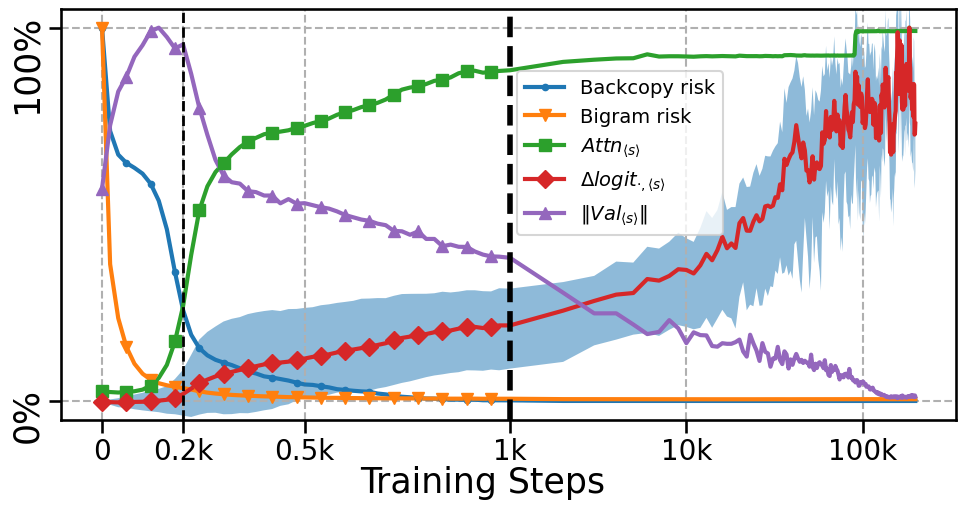

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

lw = 3
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(x_keys_1, icl_y_1, lw=lw, color=colors[0])
ax.plot(x_keys_1, markov_y_1, lw=lw, color=colors[1])
ax.plot(x_keys_1, attns_on_bos_y_1, lw=lw, color=colors[2])
ax.plot(x_keys_1, logit_y_1, lw=lw, color=colors[3])
ax.fill_between(x_keys_1, logit_y_lower_1, logit_y_upper_1, alpha=0.5)
ax.plot(x_keys_1, value_states_y_1, lw=lw, color=colors[4])
ax.grid(linestyle='--')
ax.plot(x_keys_2, icl_y_2, marker='.', lw=0, color=colors[0])
ax.plot(x_keys_2, markov_y_2, marker='v', lw=0, color=colors[1])
ax.plot(x_keys_2, attns_on_bos_y_2, marker='s', lw=0, color=colors[2])
ax.plot(x_keys_2, logit_y_2, marker='D', lw=0, color=colors[3])
ax.plot(x_keys_2, value_states_y_2, marker='^', lw=0, color=colors[4])
# add legends
ax.plot(0, -1, marker='.', label='Backcopy risk', lw=lw, color=colors[0])
ax.plot(0, -1, marker='v', label='Bigram risk', lw=lw, color=colors[1])
ax.plot(0, -1, marker='s', label=r'$Attn_{\langle s\rangle}$', lw=lw, color=colors[2])
ax.plot(0, -1, marker='D', label=r'$\Delta logit_{\cdot,\langle s\rangle}$', lw=lw, color=colors[3])
ax.plot(0, -1, marker='^', label=r'$\|Val_{\langle s \rangle}\|$', lw=lw, color=colors[4])

ax.set_yticks([0, 1])
ax.set_ylim(-0.05, 1.05)
ax.vlines(1006, -0.05, 1.15, linestyle='--', color='black', lw=4)
ax.vlines(200, -0.05, 1.15, linestyle='--', color='black', lw=2)
ax.set_yticklabels(['0%', '100%'], fontsize=fontsize, rotation=90)

ax.set_xticks(x_keys_1[tickx])
ax.set_xticklabels(['0', '0.2k', "0.5k", '1k', '10k', '100k'], fontsize=12)
ax.grid(linestyle='--')
for line in ax.get_xgridlines():
    if np.abs(line.get_xdata()[0] - 1000) < 10:  # Check if the line is at x=1000
        line.set_visible(False)  # Hide the line
fig.text(0.5, -0.02, 'Training Steps', ha='center', fontsize=fontsize)
plt.tight_layout()
# plt.legend(fontsize=12)
plt.legend(fontsize=14, loc='center right', bbox_to_anchor=(0.75, 0.65))
plt.xticks(fontsize=20)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(dir_name, "dynamics_combine.pdf"), bbox_inches='tight')

## plots for the ReLu Attn

In [36]:
torch.cuda.set_device(3)
device = 'cuda:3'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/pre-iclr/dynamics/ReLU_attn"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(3.9337e-06, device='cuda:3', grad_fn=<MeanBackward0>),
 tensor(2.2284, device='cuda:3', grad_fn=<MeanBackward0>))

In [37]:
unique_x = torch.unique(x)
outputs_norms = {}
logits = {}
value_states_norm = {}
icl_risks = {}
markov_risks = {}
attns_on_bos = {}

with torch.no_grad():
    for step in tqdm(torch.arange(0, 2001, 20).tolist()):
        model_loader.change_steps(step)
        model, _, optim = model_loader(with_data=False,)
        pred, outputs_list = model.modified_forward_with_hook(x, hook)
        outputs_norms[step] = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item()
        logits[step] = summarise_attns(outputs_list[0]['attn_logits'][:, 0, :, 0], x, unique_x)
        attns_on_bos[step] = outputs_list[0]['attn_weights'][:, 0, :, 0][~triggers_pos].mean().detach().item()
        value_states_norm[step] = model.layers[0].attention.wo(outputs_list[0]['value_states'][idx, 0, 0, :].cuda()).norm(dim=-1).detach().cpu().numpy()
        risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
        icl_risks[step] = risk[1].item()
        markov_risks[step] = risk[2].item()
logit_summary = torch.stack(list(logits.values()), dim=0)

  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:08<00:00, 11.63it/s]


In [38]:
stop_step = 55
step_size = 5
x_keys = list(icl_risks.keys())[:stop_step][::step_size]
icl_y = np.array(list(icl_risks.values()))
icl_y = icl_y / icl_y.max()
markov_y = np.array(list(markov_risks.values()))
markov_y = markov_y - oracle_risk[2].item()
markov_y = markov_y / markov_y.max()
value_states_y = np.array(list(value_states_norm.values()))
value_states_y = value_states_y / value_states_y.max()
attns_on_bos_y = np.array(list(attns_on_bos.values()))
attns_on_bos_y = attns_on_bos_y


icl_y = icl_y[:stop_step][::step_size]
markov_y = markov_y[:stop_step][::step_size]
value_states_y = value_states_y[:stop_step][::step_size]
attns_on_bos_y = attns_on_bos_y[:stop_step][::step_size]

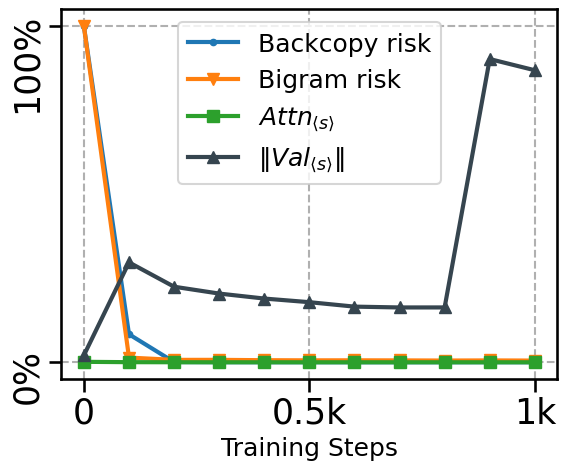

In [39]:
lw = 3
fig, ax = plt.subplots()
ax.plot(x_keys, icl_y, label='Backcopy risk', marker='.', lw=lw)
ax.plot(x_keys, markov_y, label='Bigram risk', marker='v', lw=lw)
ax.plot(x_keys, attns_on_bos_y, label=r'$Attn_{\langle s\rangle}$', marker='s', lw=lw)
ax.plot(x_keys, value_states_y, marker='^', color='#36454F', label=r'$\|Val_{\langle s\rangle}\|$', lw=lw)
ax.grid(linestyle='--')
ax.set_yticks([0, 1])
ax.set_yticklabels(['0%', '100%'], fontsize=fontsize, rotation=90)
ax.set_xticks([0, 500, 1000])
ax.set_xticklabels([0, "0.5k", '1k'], fontsize=fontsize)
plt.xlabel('Training Steps', fontsize=18)
plt.grid(linestyle='--')
plt.legend(fontsize=18)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(dir_name, "relu_dynamics.pdf"),bbox_inches='tight')
plt.show()

## 3 layers

## we first show that the minimal structure to recover the massive norm

In [48]:
run_path_server = "~/gens/pre-iclr/dynamics/bbm_simplified"
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_long_train_redo"
model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(2, ), no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)

In [49]:
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
unique_x = torch.unique(x)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
with torch.no_grad():
    hook = forward_hook([], '')
    pred, outputs_list = model.modified_forward_with_hook(x, hook)
    probs = get_oracle_predicts(x, ds)
    risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
_, logits = summarise_logits_difference(outputs_list[1]['attn_logits'][:, 0, ...], x, unique_x)
# _, logits_2 = summarise_logits_difference(outputs_list[2]['attn_logits'][:, 0, ...], x, unique_x)
logit_full = logits[logits>0].mean().item()
norm_full = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item() - outputs_list[0]['output'][:, 1:, :].norm(dim=-1).mean().item()
value_norm_full = model.layers[1].attention.wo(outputs_list[1]['value_states'][0, 0, 0, :]).norm().item()
risk[1:3]

(tensor(4.1685e-05, device='cuda:3'), tensor(2.2291, device='cuda:3'))

In [50]:
with torch.no_grad():
    hook = check_embed(target_layers=[0, 1, 2], target_heads=[(0, 0),], target_mlp_layers=[0])
    pred, outputs_list = model.modified_forward_with_hook(x, hook)
    probs = get_oracle_predicts(x, ds)
    risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
_, logits = summarise_logits_difference(outputs_list[1]['attn_logits'][:, 0, ...], x, unique_x)
# _, logits_2 = summarise_logits_difference(outputs_list[2]['attn_logits'][:, 0, ...], x, unique_x)
logit_no_0 = logits[logits>0].mean().item()
norm_no_0 = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item() - outputs_list[0]['output'][:, 1:, :].norm(dim=-1).mean().item()
value_norm_no_0 = model.layers[1].attention.wo(outputs_list[1]['value_states'][0, 0, 0, :]).norm().item()
risk[1:3]


(tensor(2.4397, device='cuda:3'), tensor(2.4740, device='cuda:3'))

In [51]:
logit_full, norm_full, value_norm_full, logit_no_0, norm_no_0, value_norm_no_0

(18.92972183227539,
 106.09174919128418,
 0.7286610007286072,
 1.9209387302398682,
 0.7056503295898438,
 10.624762535095215)

In [52]:
outputs_list[1]['attn_weights'][0, 0, :10, :10]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.8629e-01, 1.3711e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.4963e-06, 9.8321e-01, 1.6790e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [6.7970e-04, 1.8847e-03, 9.9462e-01, 2.8200e-03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.0978e-01, 5.4815e-05, 2.9284e-03, 5.8717e-01, 6.9747e-05, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.4906e-01, 6.4598e-05, 3.0234e-04, 4.5991e-04, 7.4978e-01, 3.3105e-04,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.9197e-03, 1.3595e-05, 5.4196e-04, 2.6143e-05, 8.4362e-05, 9.9636e-01,
         5.6742e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9990e-05, 3.8343

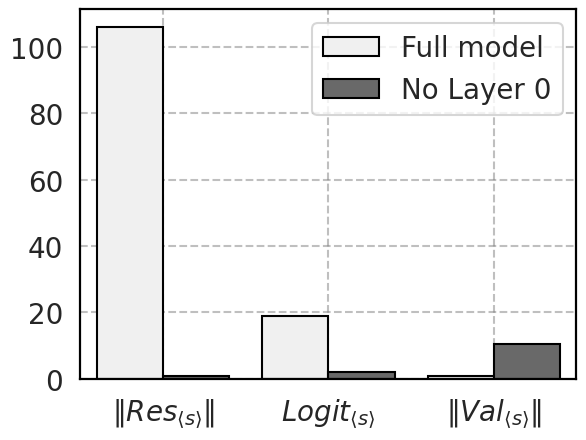

In [53]:
import pandas as pd

# Define groups and categories
groups = ['Full model', 'No Layer 0']
categories = [r'$\|Res_{\langle s\rangle}\|$', r'$Logit_{\langle s\rangle}$', r'$\|Val_{\langle s\rangle}\|$']

# Define values for each group and category
values_full = [norm_full, logit_full, value_norm_full]
values_no_0 = [norm_no_0, logit_no_0, value_norm_no_0]

# Combine values for the two groups
df = pd.DataFrame({
    'Group': np.repeat(groups, len(categories)),
    'Value': values_full + values_no_0,
    'Category': categories * 2
})

# Create the plot
with sns.axes_style("whitegrid"):
    sns.set_context("talk")
    fig, ax = plt.subplots()

    # Create the Seaborn bar plot
    custom_colors = ['#f0f0f0', "#696969",]
    sns.barplot(x='Category', y='Value', hue='Group', data=df, palette=custom_colors, edgecolor='black', ax=ax)

    # Customize the grid and spines
    ax.grid(False, axis='y')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.6)

    # Customize x-ticks and y-ticks
    plt.xticks(rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('', fontsize=20)  # You can adjust the fontsize

    # Set legend
    ax.legend(fontsize=20)

    # Customize tick font sizes
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(linestyle='--', color='grey', alpha=0.5)

# Save or show the plot
plt.savefig(os.path.join(dir_name, "massive_interventions.pdf"), bbox_inches='tight')
plt.show()

## dynamics of massive norms

In [51]:

if recompute:
    unique_x = torch.unique(x)
    outputs_norms = {}
    outputs_norms_sgd = {}
    outputs_norms_relu = {}

    logits = {}
    logits_sgd = {}
    logits_relu = {}

    run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"

    model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(), no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)

    run_path_server_sgd = "~/gens/pre-iclr/dynamics/bbm_sgd"

    model_loader_sgd = ModelLoader(run_path_local=None, run_path_server=run_path_server_sgd, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(), no_ffn=(), linear_ffn=(), lr=0.03, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)

    run_path_server_relu = "~/gens/pre-iclr/dynamics/ReLU_attn"

    model_loader_relu = ModelLoader(run_path_local=None, run_path_server=run_path_server_relu, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(), no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)

    with torch.no_grad():
        for step in tqdm(torch.arange(0, 1001, 20).tolist()+torch.arange(1000, 10001, 20).tolist()):
            model_loader.change_steps(step)
            model, _, optim = model_loader(with_data=False,)
            pred, outputs_list = model.modified_forward_with_hook(x, hook)
            outputs_norms[step] = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item()
            logits[step] = summarise_attns(outputs_list[0]['attn_logits'][:, 0, :, 0], x, unique_x)

            model_loader_sgd.change_steps(step)
            model, _, _ = model_loader_sgd(with_data=False, with_optim=False)
            pred, outputs_list = model.modified_forward_with_hook(x, hook)
            outputs_norms_sgd[step] = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item()
            logits_sgd[step] = summarise_attns(outputs_list[0]['attn_logits'][:, 0, :, 0], x, unique_x)

            model_loader_relu.change_steps(step)
            model, _, _ = model_loader_relu(with_data=False, with_optim=False)
            pred, outputs_list = model.modified_forward_with_hook(x, hook)
            outputs_norms_relu[step] = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item()
            logits_relu[step] = summarise_attns(outputs_list[0]['attn_logits'][:, 0, :, 0], x, unique_x)


    logit_summary = torch.stack(list(logits.values()), dim=0)
    logit_summary_sgd = torch.stack(list(logits_sgd.values()), dim=0)
    logit_summary_relu = torch.stack(list(logits_relu.values()), dim=0)
    torch.save((outputs_norms, outputs_norms_sgd, outputs_norms_relu, logit_summary, logit_summary_sgd, logit_summary_relu), "~/figures/BBM/massive_dynamics_sgd_relu.pt")
else:
    outputs_norms, outputs_norms_sgd, outputs_norms_relu, logit_summary, logit_summary_sgd, logit_summary_relu = torch.load("~/figures/BBM/massive_dynamics_sgd_relu.pt")

In [52]:
step_size = 20
x_keys = list(outputs_norms.keys())
norms_y = np.array(list(outputs_norms.values()))
norms_sgd_y = np.array(list(outputs_norms_sgd.values()))
norms_relu_y = np.array(list(outputs_norms_relu.values()))
x_keys = x_keys[::step_size]
norms_y = norms_y[::step_size]
norms_sgd_y = norms_sgd_y[::step_size]
norms_relu_y = norms_relu_y[::step_size]

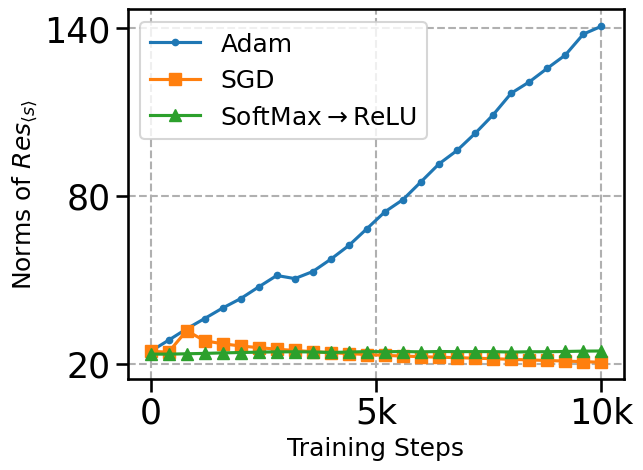

In [53]:
fig, ax = plt.subplots()
ax.plot(x_keys, norms_y, marker='.', label='Adam')
ax.plot(x_keys, norms_sgd_y, marker='s', label='SGD')
ax.plot(x_keys, norms_relu_y, marker='^', label=r'SoftMax$\to$ReLU')

ax.set_xticks([0, 5000, 10000])
ax.set_xticklabels(['0', '5k', '10k'],)
ax.set_yticks([20, 80, 140])
plt.ylabel(r'Norms of $Res_{\langle s \rangle}$', fontsize=18)
plt.xlabel('Training Steps', fontsize=18)
plt.grid(linestyle='--')
plt.legend(fontsize=18)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(dir_name, "adam_vs_sgd.pdf"), bbox_inches='tight')
plt.show()